<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Small-example-of-single-edge-contribution" data-toc-modified-id="Small-example-of-single-edge-contribution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Small example of single edge contribution</a></span><ul class="toc-item"><li><span><a href="#Define-QAOA-problem" data-toc-modified-id="Define-QAOA-problem-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define QAOA problem</a></span><ul class="toc-item"><li><span><a href="#Create-graph" data-toc-modified-id="Create-graph-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Create graph</a></span></li><li><span><a href="#Create-QAOA-params" data-toc-modified-id="Create-QAOA-params-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Create QAOA params</a></span></li></ul></li><li><span><a href="#Calculate-Loss" data-toc-modified-id="Calculate-Loss-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate Loss</a></span></li><li><span><a href="#Calculate-gradient" data-toc-modified-id="Calculate-gradient-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calculate gradient</a></span></li><li><span><a href="#Do-gradient-descent" data-toc-modified-id="Do-gradient-descent-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Do gradient descent</a></span></li><li><span><a href="#Plot-parameter-space-with-descent-path" data-toc-modified-id="Plot-parameter-space-with-descent-path-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plot parameter space with descent path</a></span></li></ul></li><li><span><a href="#Use-Adam-optimizer-(and-others)" data-toc-modified-id="Use-Adam-optimizer-(and-others)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use Adam optimizer (and others)</a></span></li><li><span><a href="#Small-playground-of-torch-autograd" data-toc-modified-id="Small-playground-of-torch-autograd-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Small playground of torch autograd</a></span><ul class="toc-item"><li><span><a href="#Incorrect-way" data-toc-modified-id="Incorrect-way-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Incorrect way</a></span></li><li><span><a href="#Correct-way" data-toc-modified-id="Correct-way-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Correct way</a></span></li></ul></li></ul></div>

# Optimizing variational parameters of Qantum Circuit

The goal of variational algorithms is to find a perfect set of parameters that minimize a particular cost.
For example, in the case of QAOA algorithm, one wants to minimize energy expectation of cost operator in state $\langle \gamma\beta|$. The cost function (or _loss_ in terms of machine learning) is $ L = \langle \gamma\beta | \hat C | \gamma \beta \rangle $

In [28]:
import qtensor
import networkx as nx
from qtensor.contraction_backends import TorchBackend

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Small example of single edge contribution

### Define QAOA problem
#### Create graph

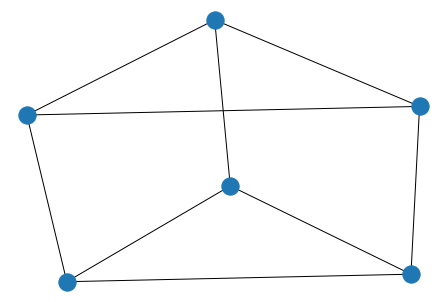

In [30]:
G = qtensor.toolbox.random_graph(nodes=6, degree=3, seed=10)
nx.draw_kamada_kawai(G)

#### Create QAOA params

The point `gamma, beta` is defined to be near a saddle point on purpose. 
This tests how vanilia gradient descent will perform in such cases.

In [315]:
p = 1
edge = list(G.edges)[0]

gamma, beta = [0.507]*p, [0.2507]*p
composer = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
composer.energy_expectation_lightcone(edge)
composer.circuit

[H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 ZZ[alpha=1.01](0,1),
 ZZ[alpha=1.01](0,3),
 ZZ[alpha=1.01](0,4),
 ZZ[alpha=1.01](1,2),
 ZZ[alpha=1.01](1,5),
 XPhase[alpha=0.50](0),
 XPhase[alpha=0.50](1),
 Z(0),
 Z(1),
 XPhase+[alpha=0.50](1),
 XPhase+[alpha=0.50](0),
 ZZ+[alpha=1.01](1,5),
 ZZ+[alpha=1.01](1,2),
 ZZ+[alpha=1.01](0,4),
 ZZ+[alpha=1.01](0,3),
 ZZ+[alpha=1.01](0,1),
 H+(5),
 H+(4),
 H+(3),
 H+(2),
 H+(1),
 H+(0)]

In [316]:
sim_np = qtensor.QtreeSimulator()
sim_np.simulate(composer.circuit)

array([0.00038601-4.90653885e-18j])

### Calculate Loss

In [317]:
import torch

In [318]:
def torch_param(x):
    return torch.tensor(x, requires_grad=True)

gamma, beta = torch_param(gamma), torch_param(beta)

In [319]:
composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
composer.energy_expectation_lightcone(edge)
composer.circuit

backend = TorchBackend()
sim = qtensor.QtreeSimulator(backend=backend)

In [320]:
sim.simulate(composer.circuit)

tensor([0.0004-1.6464e-09j], grad_fn=<ViewBackward>)

In [321]:
loss = -torch.real(sim.simulate(composer.circuit))
loss

tensor([-0.0004], grad_fn=<NegBackward>)

### Calculate gradient

In [322]:
loss.grad_fn

In [323]:
loss.backward(retain_graph=True)

In [324]:
print('Gamma gradient =', gamma.grad)
print('Beta gradient =', beta.grad)

Gamma gradient = tensor([-0.0549])
Beta gradient = tensor([-0.5514])


### Do gradient descent


A helpful article about using bare-bones autograd in pytoch: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#40de

About complex-valued autograd: https://pytorch.org/docs/stable/notes/autograd.html#complex-autograd-doc

Since the common optimization problem in ML is minimization, we'll negate the loss.
This will help using advanced optimizers later

**Loss**

$$ L = - \Re( \langle \gamma \beta | \hat C | \gamma \beta \rangle) $$

In [325]:
lr = 3e-3
losses = []
steps = 20
param_history = []

In [326]:
gamma, beta = torch_param([0.507]*p), torch_param([0.2507]*p)

for i in range(steps):
    print()
    param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))
    composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    loss = -torch.real(sim.simulate(composer.circuit))
    losses.append(loss.detach().numpy())
    print('loss =', losses[-1])
    
    loss.backward(retain_graph=True)
    
    with torch.no_grad():
        gamma -= lr*gamma.grad
        beta -= lr*beta.grad
        
    print('Params', gamma, beta)
    print('Grads', gamma.grad, beta.grad)
    gamma.grad.zero_()
    beta.grad.zero_()


loss = [-0.00038602]
Params tensor([0.5072], requires_grad=True) tensor([0.2524], requires_grad=True)
Grads tensor([-0.0549]) tensor([-0.5514])

loss = [-0.00132851]
Params tensor([0.5077], requires_grad=True) tensor([0.2540], requires_grad=True)
Grads tensor([-0.1845]) tensor([-0.5641])

loss = [-0.0024583]
Params tensor([0.5087], requires_grad=True) tensor([0.2559], requires_grad=True)
Grads tensor([-0.3167]) tensor([-0.6070])

loss = [-0.00399847]
Params tensor([0.5100], requires_grad=True) tensor([0.2579], requires_grad=True)
Grads tensor([-0.4581]) tensor([-0.6802])

loss = [-0.00623141]
Params tensor([0.5119], requires_grad=True) tensor([0.2603], requires_grad=True)
Grads tensor([-0.6147]) tensor([-0.7854])

loss = [-0.00954458]
Params tensor([0.5143], requires_grad=True) tensor([0.2630], requires_grad=True)
Grads tensor([-0.7925]) tensor([-0.9247])

loss = [-0.01448263]
Params tensor([0.5173], requires_grad=True) tensor([0.2663], requires_grad=True)
Grads tensor([-0.9962]) tens

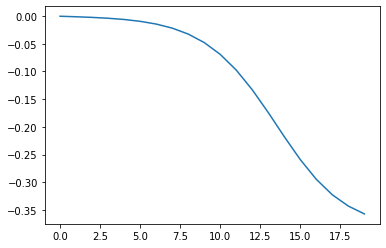

In [327]:
import matplotlib.pyplot as plt
plt.plot(losses)

### Plot parameter space with descent path

In [328]:
from cartesian_explorer import Explorer
ex = Explorer()

In [329]:
@ex.provider
def single_edge_contribution(graph, gamma, beta):
    composer = qtensor.DefaultQAOAComposer(graph, gamma=[gamma], beta=[beta])
    composer.circuit
    edge = list(graph.edges)[0]
    composer.energy_expectation_lightcone(edge)
    sim_np = qtensor.QtreeSimulator()
    return sim_np.simulate(composer.circuit)

In [333]:
gamma_arr = list(np.linspace(0, 1/1, 30))
beta_arr = list(np.linspace(0, 1/2, 30))

In [331]:
arr = ex.map_variable('single_edge_contribution', graph=[G], gamma=gamma_arr, beta=beta_arr)

In [332]:
print('Max value', np.real(arr).max())

Max value 0.3829751639726484


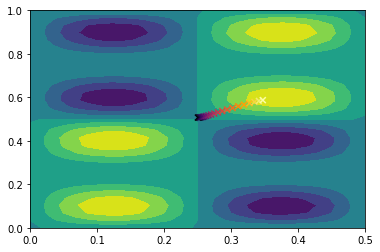

In [334]:
plt.contourf(beta_arr, gamma_arr, arr.reshape(len(gamma_arr), len(beta_arr)))

gammas, betas = zip(*param_history)
plt.scatter(betas, gammas, marker='x', c=range(len(param_history)), cmap='inferno')

---

## Use Adam optimizer (and others)

This optimizer will work even when the starting point is exactly the saddle point.
Gradient descent will not work in this case


Another good optimizer is Adagrad, which shows even better results for the saddle point.
However, it does not have momentum, so will tend to converge to local minima on more complicated surfaces.


An overview of different optimizers: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

Short summary, in the order of advanceness:

- **Gradient descent** -- the simplest, good for demos;
- **Momentum** -- adds inertia to the parameter point, better handles local minima;
- **AdaGrad** -- better handling of saddle points through scaling of learning rate based on value of grads;
- **RMSProp** -- speeds up convergence of previous by adding decay to the learning rate factor;
- **Adam** -- momentum + RMSProp. 

The last three do not need learning rate tuning.

For this toy example the best is `RMSProp`, which converges in 5 (five!) steps from exactly the saddle point.

In [425]:
def get_loss(G, gamma, beta):
    composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
    edge = list(G.edges)[0]
    composer.energy_expectation_lightcone(edge)
    loss = - torch.real(sim.simulate(composer.circuit))
    return loss

gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)

opt = torch.optim.RMSprop(params=(gamma, beta))

In [426]:
losses = []
steps = 40
param_history = []
param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))

for i in range(steps):
    loss = get_loss(G, gamma, beta)
    opt.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function
    opt.step()
    
    losses.append(loss.detach().numpy().data)
    param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))

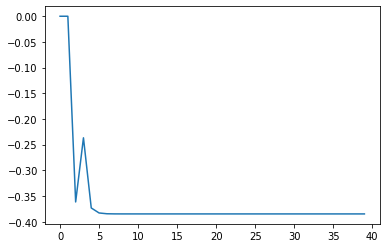

In [427]:
plt.plot(losses)

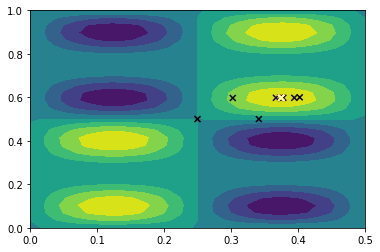

In [428]:
plt.contourf(beta_arr, gamma_arr, np.real(arr).reshape(len(gamma_arr), len(beta_arr)))

gammas, betas = zip(*param_history)
plt.scatter(betas, gammas, marker='x', c=range(len(param_history)), cmap='inferno')

## Small playground of torch autograd

In [68]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [64]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [66]:
gamma + 2

tensor([2.3000, 2.3000], grad_fn=<AddBackward0>)

In [10]:
from qtensor.OpFactory import TorchFactory, QtreeFactory

In [ ]:
param = torch.tensor(0.13, requires_grad=True)
ZZ = TorchFactory.ZZ(0, 1, alpha=param)
ZZ.gen_tensor()

In [24]:
import numpy as np
def torch_exp(z):
    """
    https://discuss.pytorch.org/t/complex-functions-exp-does-not-support-automatic-differentiation-for-outputs-with-complex-dtype/98039/3
    """
    return torch.cos(z) + 1j * torch.sin(z)

### Incorrect way

In [14]:
alpha = torch.tensor(0.13, requires_grad=True)
p = torch_exp(1j*np.pi*alpha/2)
m = torch_exp(-1j*np.pi*alpha/2)
tensor = torch.tensor([ [m, p] ,[p, m] ])

In [15]:
tensor

tensor([[1.2265+0.j, 0.8153+0.j],
        [0.8153+0.j, 1.2265+0.j]])

### Correct way

In [99]:
alpha = torch.tensor(0.13, requires_grad=True)
tensor = torch.tensor([[0, 1], [1, 0.]])
e_ = torch_exp(1j*np.pi*alpha/2)
tensor = tensor*e_
tensor

tensor([[0.0000+0.j, 0.8153+0.j],
        [0.8153+0.j, 0.0000+0.j]], grad_fn=<MulBackward0>)

In [100]:
tensor*torch.tensor([[0.1,0],[10,15]])

tensor([[0.0000+0.j, 0.0000+0.j],
        [8.1530+0.j, 0.0000+0.j]], grad_fn=<MulBackward0>)

In [103]:
tensor = torch.tensor([[-1, 1],[1, -1]])
torch_exp(1j*tensor*np.pi*alpha/2)

tensor([[1.2265+0.j, 0.8153+0.j],
        [0.8153+0.j, 1.2265+0.j]], grad_fn=<AddBackward0>)